In [160]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import tensorflow as tf 
import tensorflow_probability as tfp 
from tensorflow.keras.layers import Input, BatchNormalization, LayerNormalization, Layer, Dense, ReLU
from tensorflow.keras import Model

from tensorflow.keras import Model
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import base_layer_utils

tfd = tfp.distributions
tfb = tfp.bijectors

color_list = ['#bcad', '#dacb']

### Define the dataset

(-2.0, 2.0)

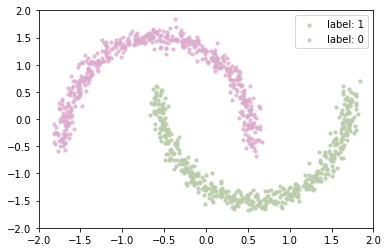

In [161]:
n_samples = 1000
split_index = int(n_samples*.75) # 75, 25 split
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

y_label = y.astype(np.bool)
X_train, Y_train = X_data[:,0], X_data[:,1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color=color_list[0])
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color=color_list[1])
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

In [162]:
X_train, y_train = X_data[:split_index].astype(np.float32), y[:split_index].astype(np.float32)
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_train = X_train.batch(128)

X_valid, y_valid = X_data[split_index:].astype(np.float32), y[split_index:].astype(np.float32)
X_valid = tf.data.Dataset.from_tensor_slices(X_valid)
X_valid = X_valid.batch(128)

### Define the base distribution

In [179]:
mvn = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2])
mvn

<tfp.distributions.Sample 'SampleNormal' batch_shape=[] event_shape=[2] dtype=float32>

### RealNVP initialization

In [190]:
class NN(Layer):
    def __init__(self, input_shape, n_hidden=[512, 512], activation="relu", name="nn"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for i, hidden in enumerate(n_hidden):
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_1'.format(i)))
            layer_list.append(Dense(hidden, activation=activation, name='dense_{}_2'.format(i)))
        self.layer_list = layer_list
        self.log_s_layer = Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t

In [191]:
class RealNVP(tfb.Bijector):
    
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        forward_min_event_ndims=1,
        validate_args: bool = False,
        name="real_nvp",
    ):
        super(RealNVP, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name="nn")
        
    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return log_s

### Transformed distribution

In [193]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                             bijector=RealNVP(input_shape=[2], n_hidden=[16,16])
                                            )
# assure variables are tracked
assert trainable_dist.trainable_variables != []

### Initialize samples

In [194]:
x = mvn.sample(sample_shape=(n_samples))
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

### Plot routine

In [195]:
def _plot(results, rows=1, legend=False, plot_color: str=color_list[0]):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color=plot_color)
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

### Prior training

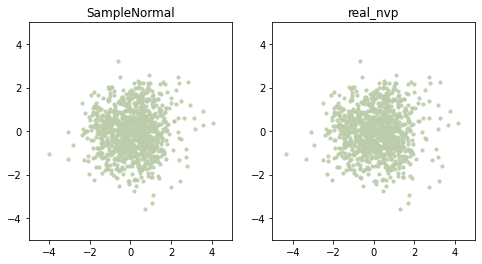

In [196]:
_plot(samples)

### Train the distribution

In [197]:
num_epochs = 600
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 200 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 200...
Epoch 400...


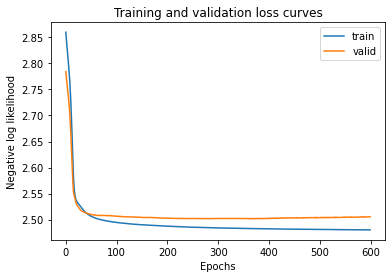

In [198]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

### After training -- w/o stacking & permutation & batch normalization

In [201]:
x = mvn.sample(sample_shape=(n_samples))
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

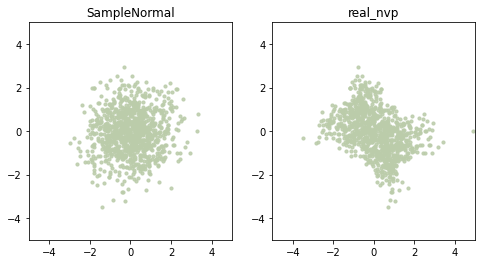

In [202]:
_plot(samples, rows=1)

### Complex model -- apply bijectors in reverse order

In [204]:
num_layers = 8
flow_bijector = []

for i in range(num_layers):
    flow_i = RealNVP(input_shape=[2], n_hidden=[512,512])
    flow_bijector.append(flow_i)  
    flow_bijector.append(tfb.Permute(permutation=[1,0]))
flow_bijector = tfb.Chain(list(reversed(flow_bijector[:-1])))

In [205]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                            bijector=flow_bijector)

### Generate samples

In [207]:
def make_samples():
    x = mvn.sample(n_samples)
    samples = [x]
    names = [mvn.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

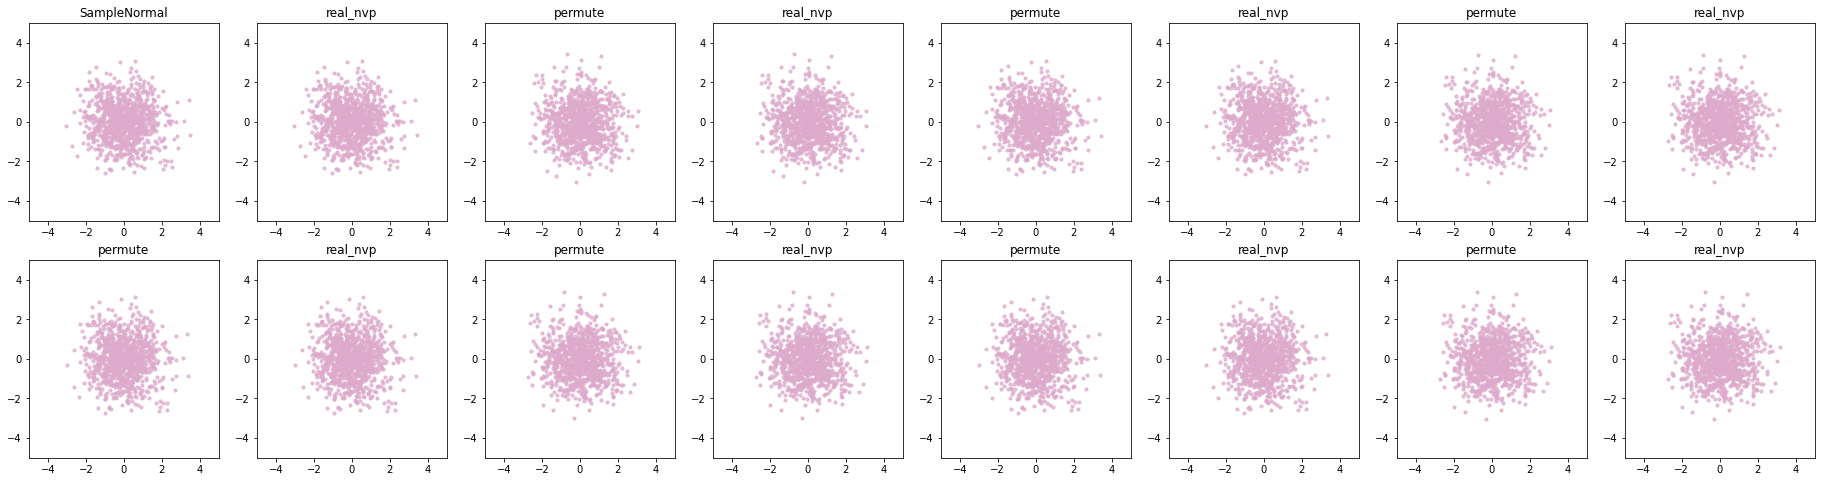

In [208]:
_plot(samples, rows=2, plot_color=color_list[1])

In [209]:
def visualize_training_data(samples, plot_color: str=color_list[0]):
    f, arr = plt.subplots(1, 2, figsize=(20,5))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color=plot_color)
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

### Visualization -- before training

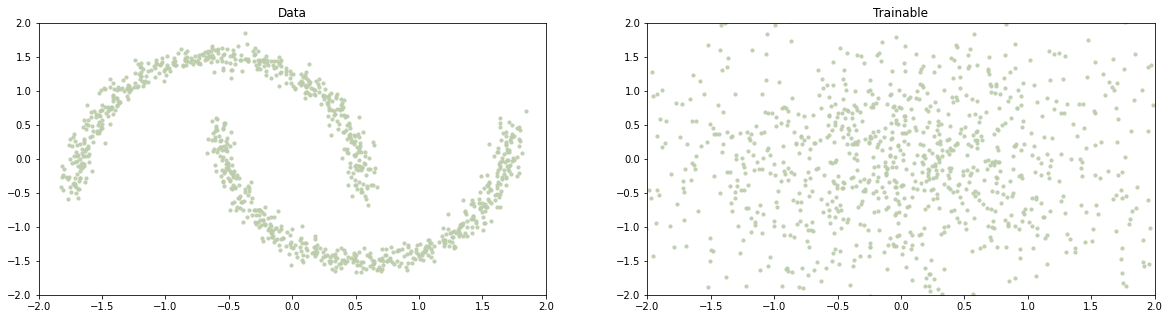

In [210]:
visualize_training_data(samples)

In [211]:
num_epochs = 600
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 200 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 200...
Epoch 400...


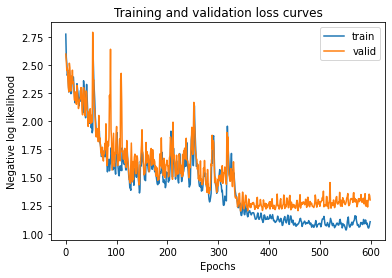

In [212]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [213]:
names, samples = make_samples()

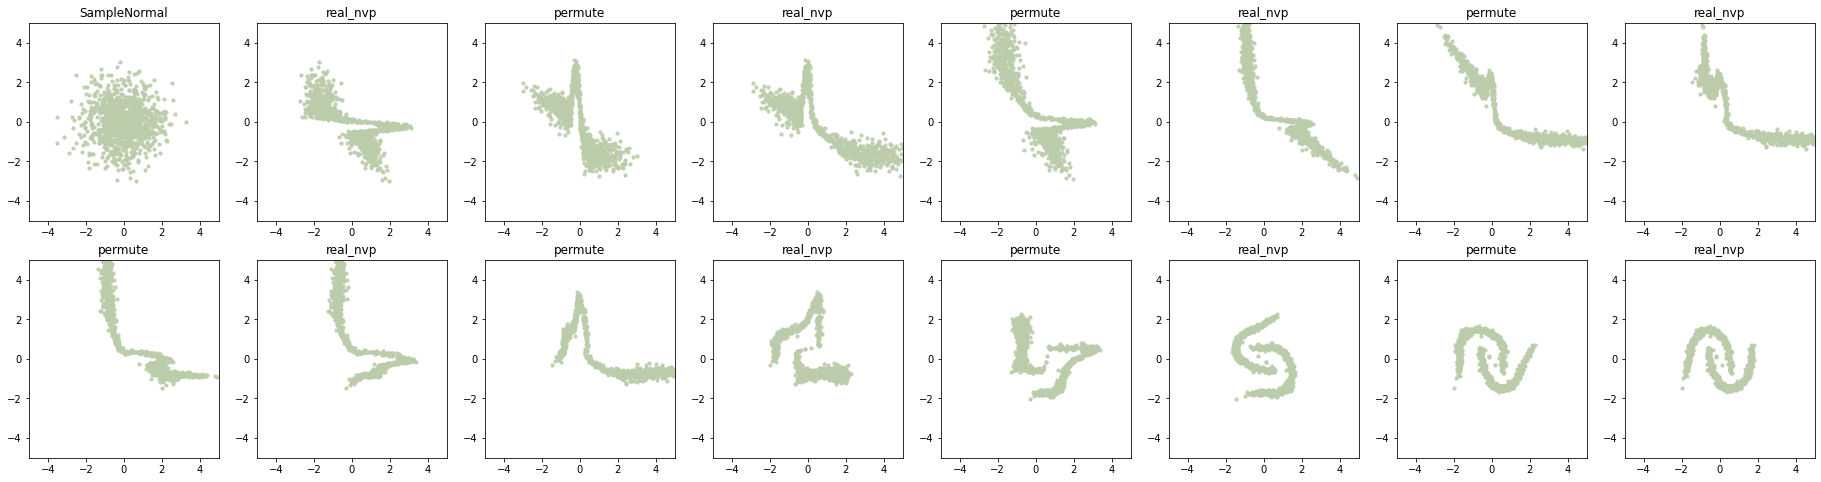

In [214]:
_plot(samples, rows=2)

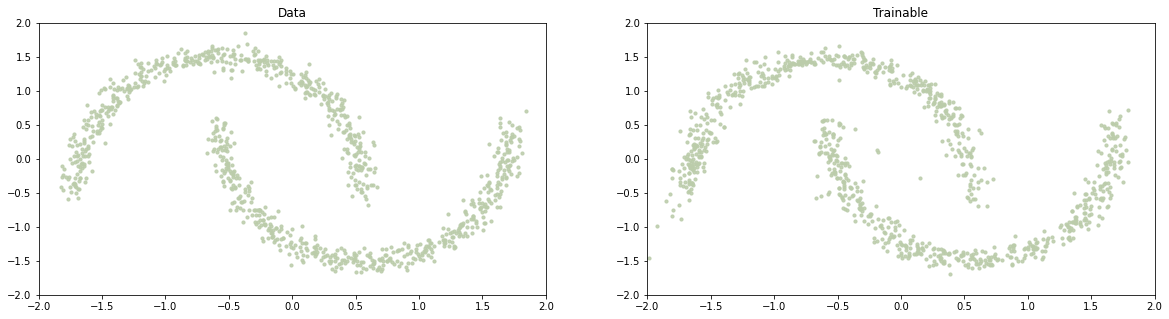

In [215]:
visualize_training_data(samples)